# Домашнее задание № 9

# Задание 1 (10 баллов)

Визуализируйте attention для одного любого текста после нескольких последовательных эпох обучения, чтобы проанализировать как модель учится понимать текст. 
Для этого вам понадобится так изменить код модели из семинара, чтобы Block класс возвращал attention активации (последнее значение wei), а также все остальные классы, которые вызывают Block, чтобы они ожидали, что модель вернет не только out но и wei. В самом верхнеуровневом классе BigramLanguageModel вы можете добавить атрибут last_attentions и в forward перезаписывать его значения последним значением attention (но можно придумать и другой способ). После каждой эпохи вызовите модель на одном примере из датасета и сохраните last_attentions во внешнюю переменную, чтобы потом отдельно заняться визуализацией. Визуализируйте attentions как heatmap'ы (например в searborn). У вас будет attention матрица для каждого слоя и для каждого head в модели. Для каждой нужно будет сделать свой хитмап.
Должно получиться что-то похожее на (только несколько для каждой эпохи)
![](https://www.kdnuggets.com/wp-content/uploads/How_to_Visualize_Model_Internals_and_Attention_in_Hugging_Face_Transformers_3.png)

### Подготовка обучающих данных

In [1]:
import pandas as pd
from rusenttokenize import ru_sent_tokenize

import pathlib

In [2]:
# Почему-то сентенизация с порога начинает поливать ворнингами:
# WARNING:root:Something went wrong while tokenizing
# WARNING:root:Something went wrong while tokenizing
# WARNING:root:Something went wrong while tokenizing

# Что ж, лучший вариант решения проблемы -- это ее игнорирование.
import logging
logging.getLogger().setLevel(logging.CRITICAL)

In [3]:
#  Подготовка данных
corpuspath = pathlib.Path().cwd() / "data" / "corpus.txt"

if corpuspath.exists():
    with open(corpuspath) as file:
        sentences = file.read().splitlines()

else:
    data = pd.read_csv('./data/lenta_40k.csv.zip')

    sentences = []
    for text in data.text.values:
        sentences.extend(ru_sent_tokenize(text))
    print(len(sentences))

    f = open('corpus.txt', 'w')
    for sent in sentences:
        f.write(sent + '\n')
    f.close()

489727


In [4]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders

In [5]:
tokenizer_name = "hw9_tokenizer"

try:
    tokenizer = Tokenizer.from_file(tokenizer_name)
except Exception:
    tokenizer = Tokenizer(BPE()) 
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix='</w>')
    tokenizer.train(files=["corpus.txt"], trainer=trainer)
    tokenizer.save(tokenizer_name)

tokenizer.decoder = decoders.BPEDecoder()
vocab_size = tokenizer.get_vocab_size()
vocab_size

30000

In [6]:
def encode(text, tokenizer):
    return (
        [tokenizer.token_to_id('[BOS]')]
        + tokenizer.encode(text).ids
        + [tokenizer.token_to_id('[EOS]')]
    )

In [7]:
PAD_IDX = tokenizer.token_to_id('[PAD]')

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, sentences, tokenizer, max_len=32):

        # каждое предложение преобразуется в последовательность индексов
        # а списки преобразуются в тензоры
        self.encoded_texts = [
            torch.LongTensor(encode(sent, tokenizer)[-max_len:])
            for sent
            in sentences
        ]

        # чтобы составить один общий обучающий тензор нужно сравнять длины последовательностей отдельных текстов
        # в торче не такая удобная функция паддинга, поэтому транкация (отрезание лишнего) происходит уже выше
        self.X = torch.nn.utils.rnn.pad_sequence(
            self.encoded_texts,
            padding_value=tokenizer.token_to_id('[PAD]'),
            batch_first=True
        )

        self.length = len(self.encoded_texts)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # обучающий пример для GPT составляется из одного текста
        # x - это все токены кроме последнего
        # y - это все токены кроме первого
        # другими словами, y это x со сдвигом вправо
        # каждый отдельный элемент в y - следующий токен для соответствующего элемента в x
        # tokens = [1,2,3,4,5,0]
        # x = [1,2,3,4,0]
        # y = [2,3,4,5,0]

        # 1 -> 2
        # 1,2 -> 3
        # 1,2,3 -> 4 
        # 1,2,3,4 -> 5
        # teacher forcing 

        x = self.X[index][:-1]
        y = self.X[index][1:]

        # чтобы не учитывать паддинг нам нужно создать маску
        mask = x!=tokenizer.token_to_id('[PAD]')

        return x, y, mask

    def get_sample_for_masked_attention(self):
        """
            Вытаскивает примерчик для визуализации атеншна
        """
        return self.__getitem__(44163)


In [10]:
n = int(0.9*len(sentences)) # first 90% will be train, rest val
sentences_train = sentences[:n]
sentences_val = sentences[n:]

In [11]:
MAX_LEN = 64

In [13]:
training_set = Dataset(sentences_train, tokenizer, MAX_LEN)
val_set = Dataset(sentences_val, tokenizer, MAX_LEN)

In [14]:
tokenizer.decode(
    val_set.get_sample_for_masked_attention()[0].numpy()
)

"Аукционный дом Christie ' s выставил на продажу вещи , пренадлежавшие звездам поп - музыки ."

In [15]:
training_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=True)
val_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=False)

### Моделька

In [16]:
# hyperparameters
block_size = MAX_LEN # what is the maximum context length for predictions?
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64 # размерность эмбеддингов и векторов внутри трансформера
#ffn_hid_dim = n_embd * 4
n_head = 4
n_layer = 4
dropout = 0.0

In [17]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        if mask is not None:
            wei.masked_fill(~mask.unsqueeze(1), float('-inf'))
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)  # <-- ПОСЛЕДНЕЕ ЗНАЧЕНИЕ wei
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out, wei

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):

        out_inp = list()
        head_attentions = list()  #  <-- тут головы

        for h in self.heads:
            o, w = h(x, mask)
            out_inp.append(o)
            head_attentions.append(w)

        out = torch.cat(out_inp, dim=-1)
        out = self.dropout(self.proj(out))
        return out, head_attentions

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, inp):

        x, mask, head_attentions = inp

        sa_, head_attentions = self.sa(self.ln1(x), mask)

        x = x + sa_
        x = x + self.ffwd(self.ln2(x))
        return x, mask, head_attentions

In [18]:
# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None, mask=None, attentions=None):

        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x, mask, head_attentions = self.blocks((x, mask, attentions)) # (B,T,C)

        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=PAD_IDX)

        return logits, loss, head_attentions

    def generate(self, idx, max_new_tokens, stop_token):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss, head_attentions = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)# (B, 1)
            if idx_next == stop_token:
                break
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [19]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

4.073392 M parameters


In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
def train(model, iterator, optimizer, print_every=10):
    epoch_loss = []
    model.train()

    for i, (xs, ys, mask) in enumerate(iterator):

        optimizer.zero_grad()
        logits, loss, head_attentions = model(xs.to(device), ys.to(device), mask.to('cuda'))

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {torch.Tensor(epoch_loss).mean(-1)}')

    return torch.Tensor(epoch_loss).mean(-1)

def evaluate(model, iterator):
    epoch_loss = []
    model.eval()
    with torch.no_grad():
        for xs, ys, mask in iterator:
            logits, loss, head_attentions = model(xs.to(device), ys.to(device), mask.to('cuda'))
            epoch_loss.append(loss.item())
    return torch.Tensor(epoch_loss).mean(-1)

def get_attentions(model, val_set):

    model.eval()
    with torch.no_grad():
        xs, ys, mask = val_set.get_sample_for_masked_attention()
        xs = xs.unsqueeze(0)
        ys = ys.unsqueeze(0)
        mask = mask.unsqueeze(0)
        logits, loss, head_attentions = model(xs.to(device), ys.to(device), mask.to('cuda'))

    return head_attentions


In [22]:
epoch_to_attentions = {}

In [23]:
train_losses = []
eval_losses = []

for i in range(30):
    print(i)
    train_losses.append(
        train(
            model,
            training_generator,
            optimizer,
            100
        )
    )

    eval_loss = evaluate(model, val_generator)
    print('Eval - ', eval_loss.item())
    eval_losses.append(eval_loss)

    for _ in range(3):
        pred = model.generate(
            torch.LongTensor(
                [[tokenizer.token_to_id('[BOS]')]]
            ).to('cuda'),
            200,
            tokenizer.token_to_id('[EOS]')
        )
        print(
            tokenizer.decoder.decode(
                [
                    tokenizer.id_to_token(i)
                    for i
                    in pred.detach().cpu().numpy()[0]
                ][1:-1]
            )
        )

    epoch_to_attentions[i] = get_attentions(model, val_set)


0
Loss: 8.568093299865723
Loss: 8.174198150634766
Loss: 7.9799299240112305
Loss: 7.8372273445129395
Loss: 7.718105316162109
Loss: 7.611836910247803
Loss: 7.51711368560791
Loss: 7.430881977081299
Loss: 7.348841190338135
Loss: 7.272122383117676
Loss: 7.199680328369141
Loss: 7.131532192230225
Loss: 7.068366050720215
Loss: 7.008302211761475
Loss: 6.951597690582275
Loss: 6.8983941078186035
Loss: 6.847774505615234
Loss: 6.800250053405762
Loss: 6.755534648895264
Loss: 6.71301794052124
Loss: 6.672427654266357
Loss: 6.633674144744873
Eval -  5.741616725921631
Как рассказали министра внутренних дел Бадшувлететь увеличилось , если речь идет о происходящих сбор разведке , сладикое он был обознавали в КХЛ обратными неравенства , а в 1988 году в соответствие Интерфакс - 24 миллиарда долларов
Соответствующее инвестиционной дела прошел 132 - 700 до 23 процентов
Голландский кольца Джэб вышло до 15 миллионов долларов и 12 суток
1
Loss: 5.730337619781494
Loss: 5.715424060821533
Loss: 5.700927734375
Loss:

KeyboardInterrupt: 

In [31]:
len(epoch_to_attentions), len(epoch_to_attentions[0]), epoch_to_attentions[0][0].squeeze(0).cpu().numpy().shape

(9, 4, (63, 63))

In [38]:
e1h1 = epoch_to_attentions[0][0].squeeze(0).cpu().numpy()

In [39]:
e1h1.shape

(63, 63)

In [40]:
type(e1h1)

numpy.ndarray

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [52]:
tokenizer.decode(val_set.get_sample_for_masked_attention()[0].cpu().numpy())

"Аукционный дом Christie ' s выставил на продажу вещи , пренадлежавшие звездам поп - музыки ."

In [61]:
sample_tokens = [
    tokenizer.id_to_token(i)
    for i
    in val_set.get_sample_for_masked_attention()[0].cpu().numpy()
    if tokenizer.id_to_token(i) != '[PAD]'  ## Подрежем паддинг
]
sample_tokens, len(sample_tokens)

(['[BOS]',
  'Ау',
  'к',
  'ционный</w>',
  'дом</w>',
  'Christie</w>',
  "'</w>",
  's</w>',
  'выставил</w>',
  'на</w>',
  'продажу</w>',
  'вещи</w>',
  ',</w>',
  'п',
  'рен',
  'адлежа',
  'вшие</w>',
  'зве',
  'зда',
  'м</w>',
  'поп</w>',
  '-</w>',
  'музыки</w>',
  '.</w>',
  '[EOS]'],
 25)

In [80]:
new_size = len(sample_tokens)

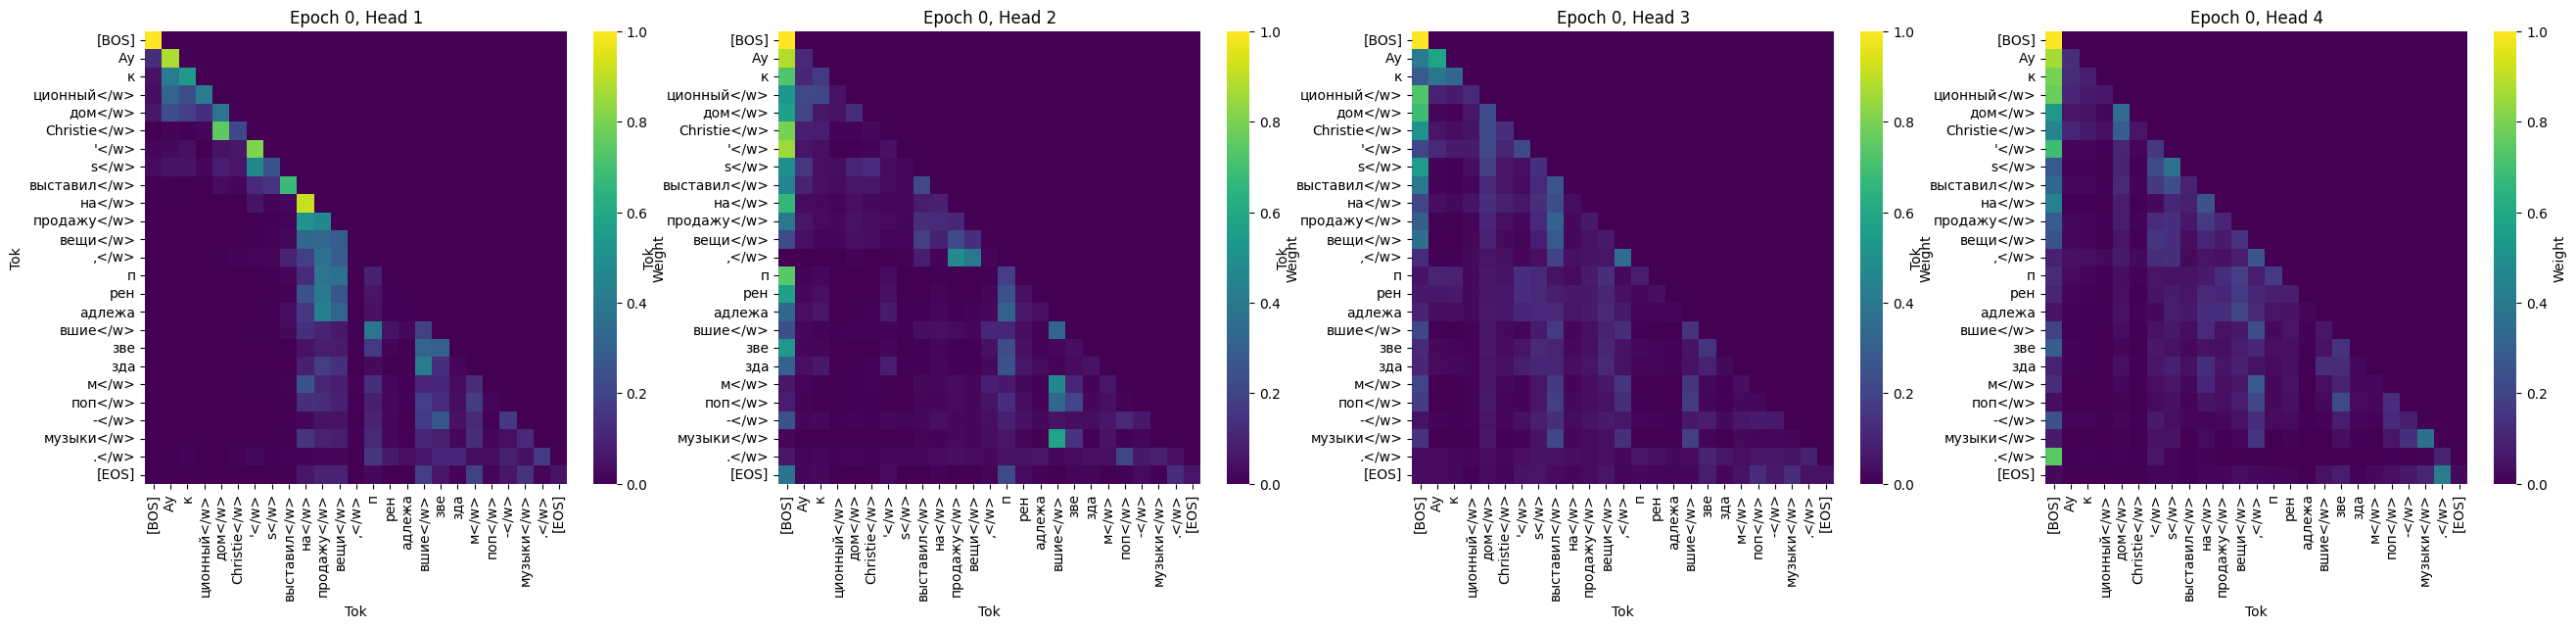

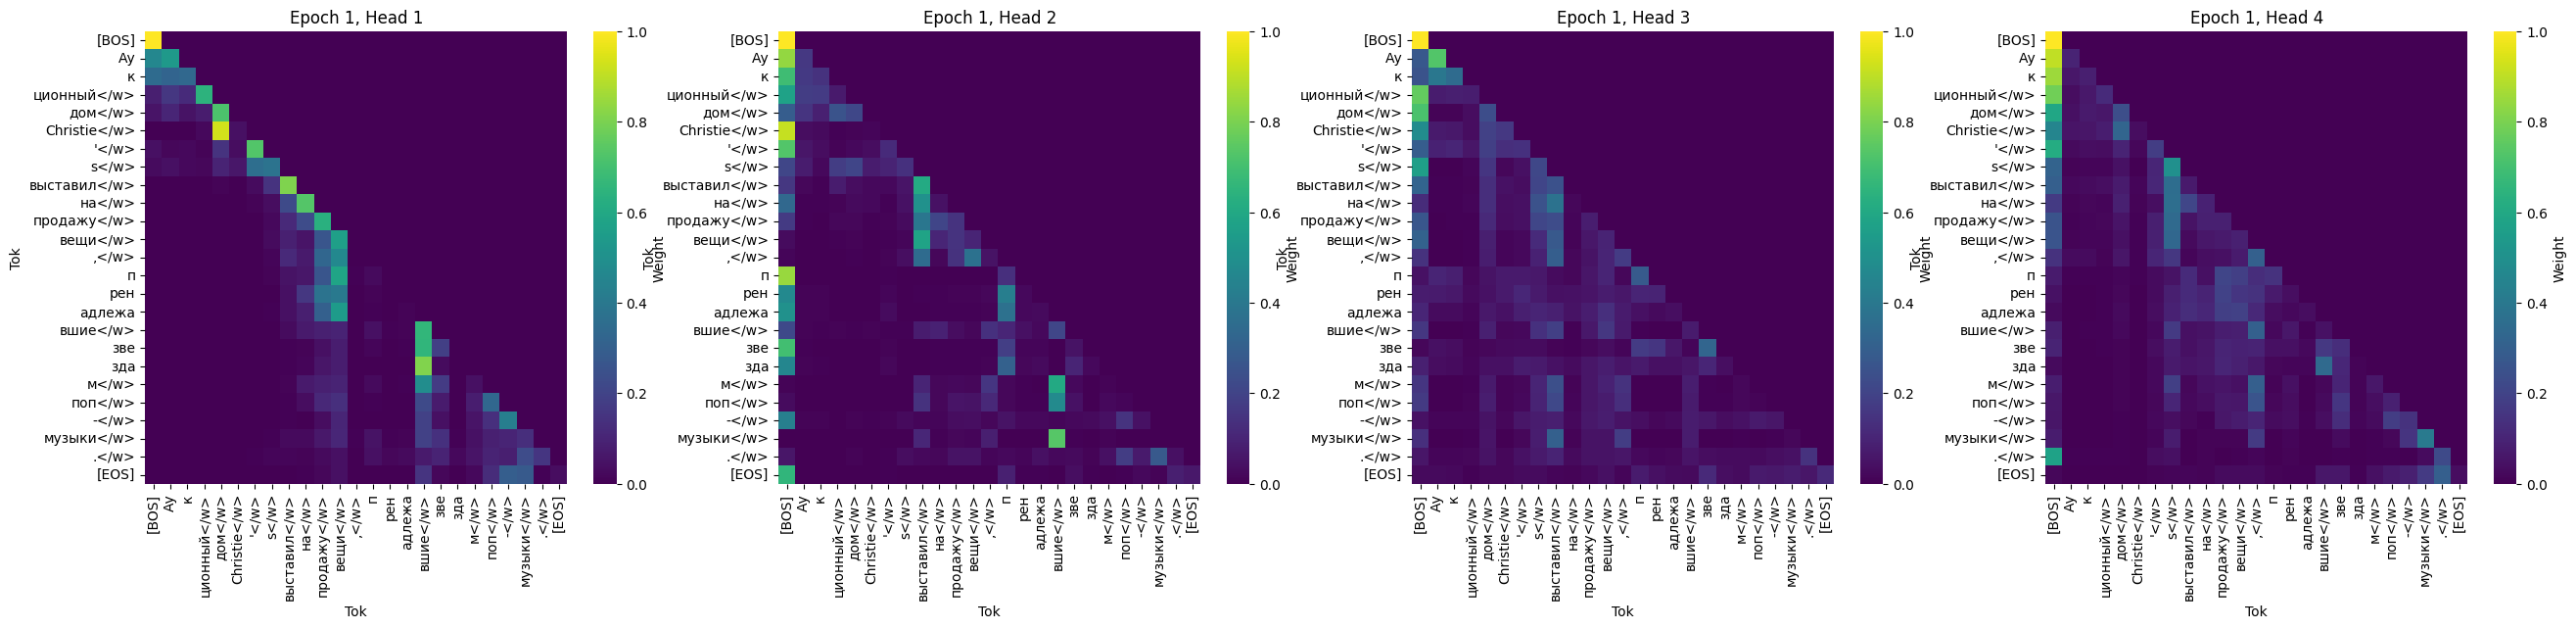

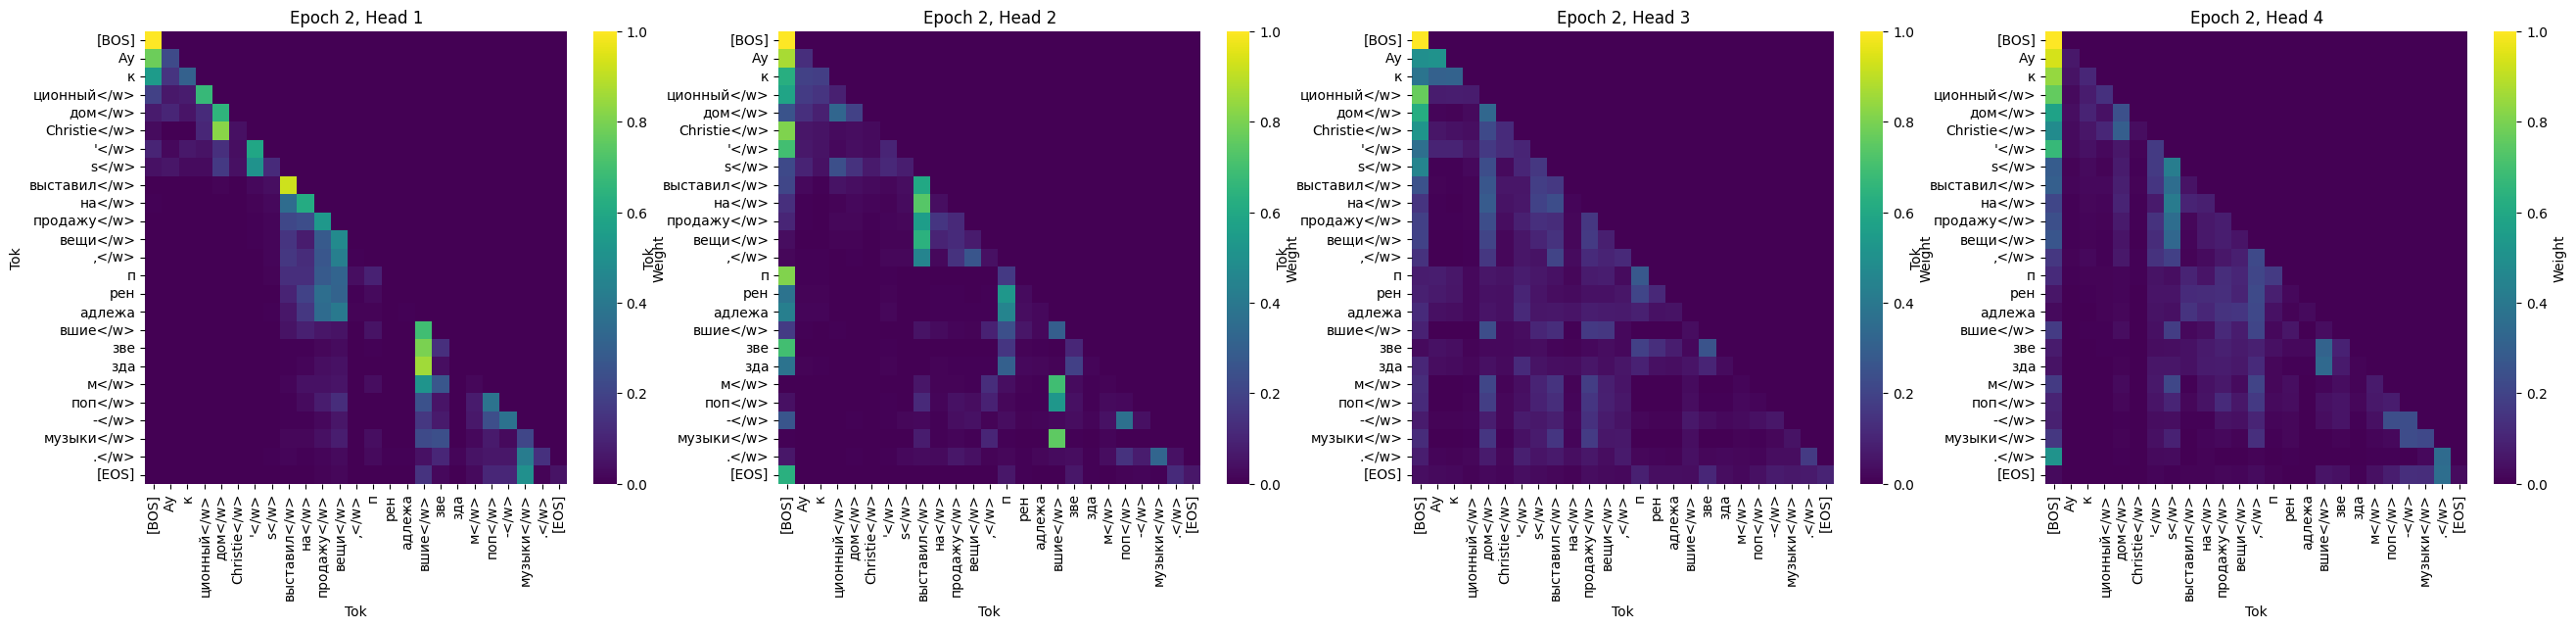

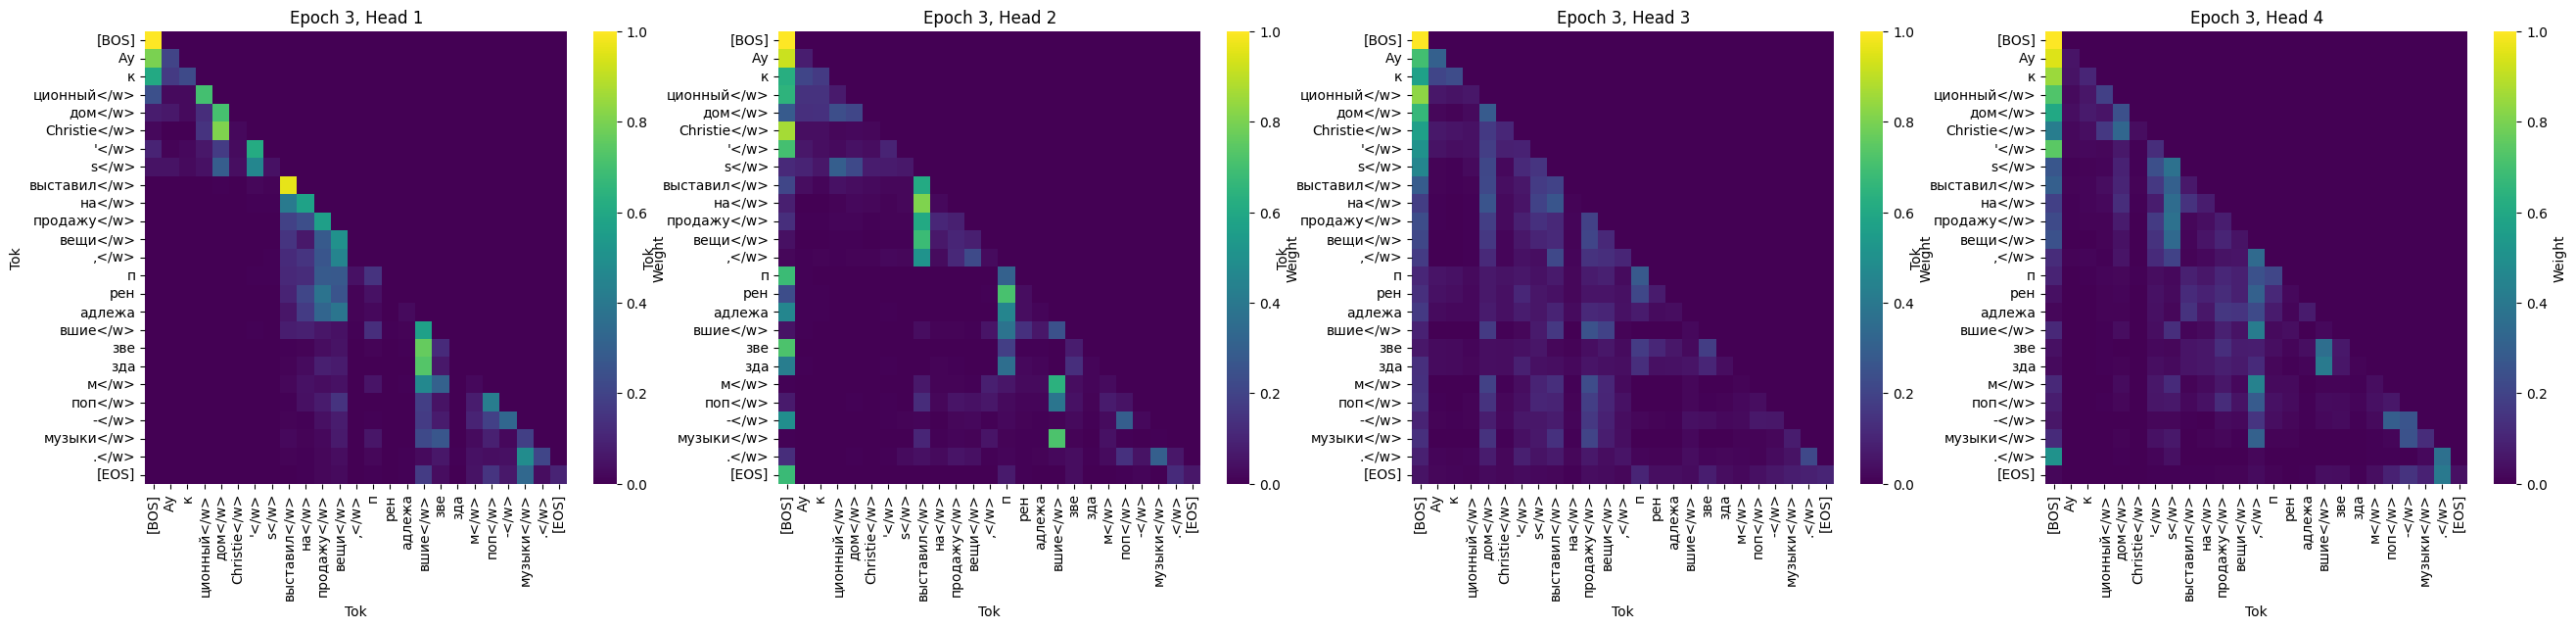

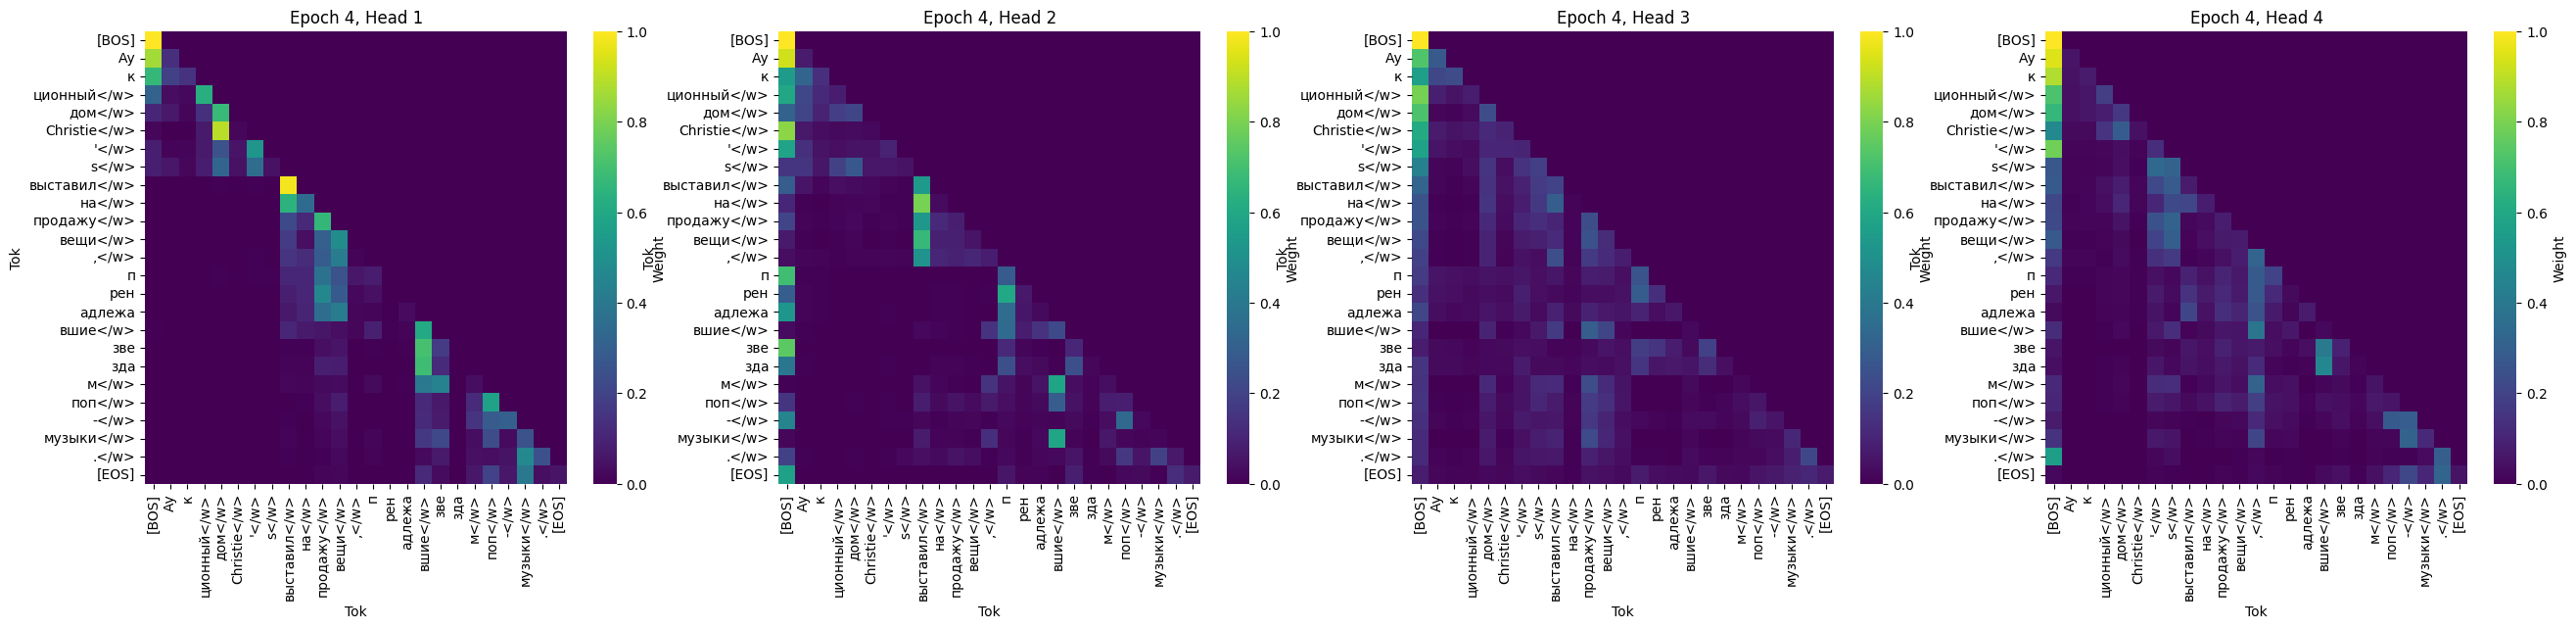

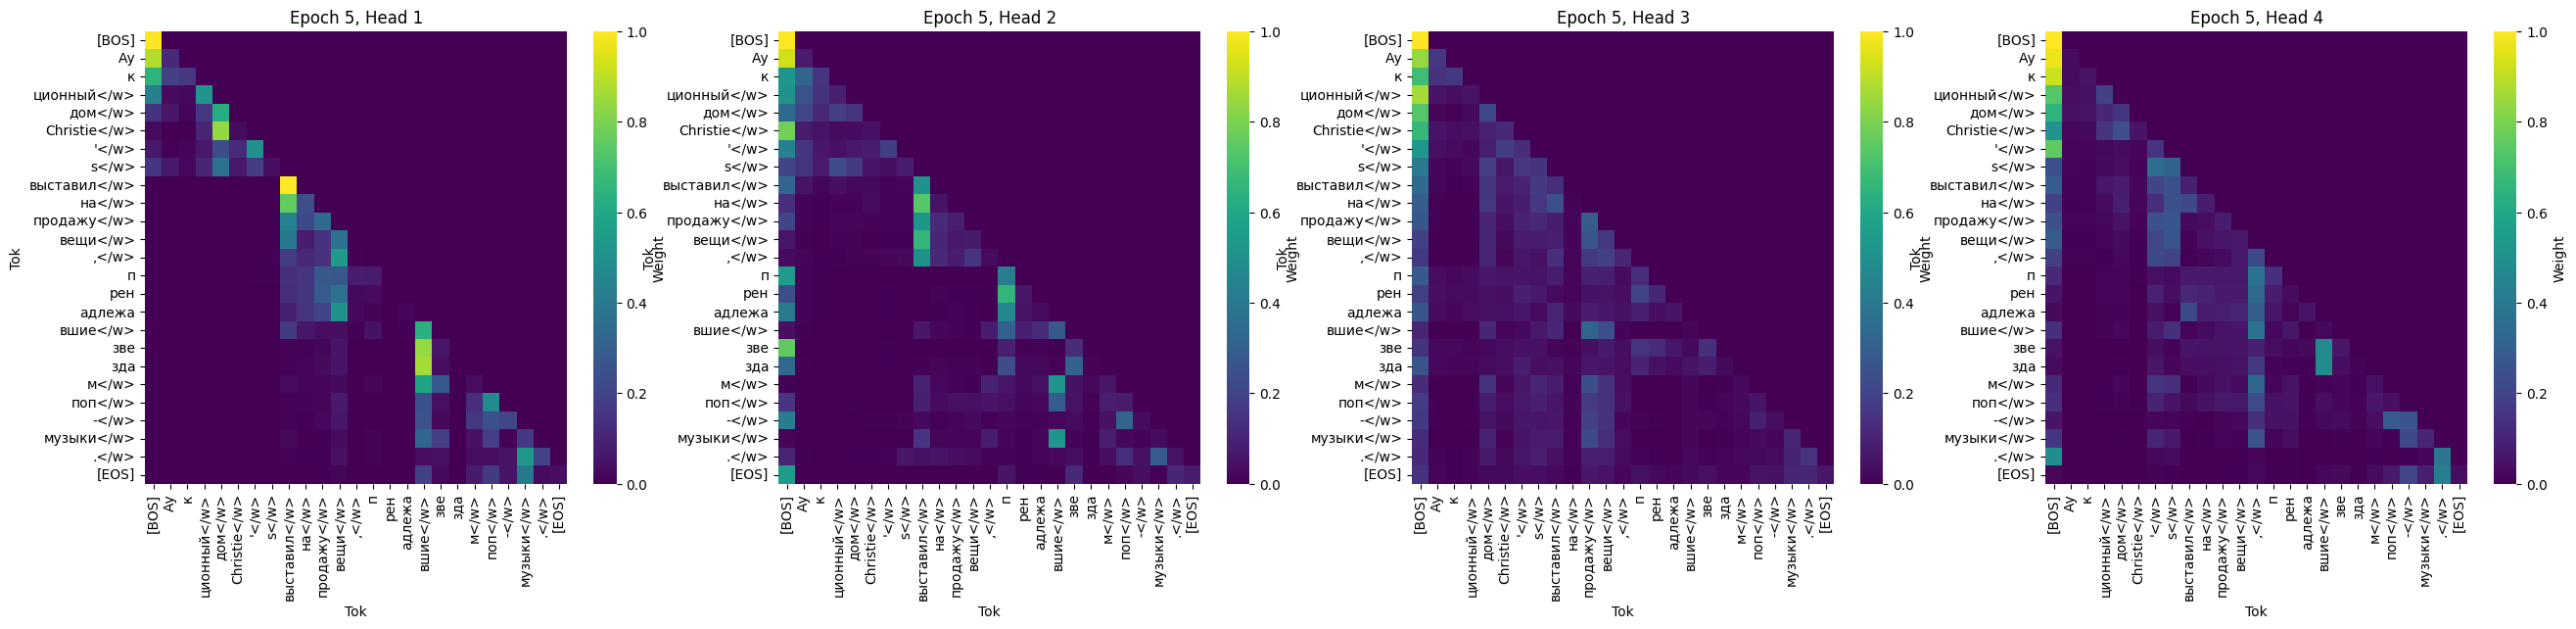

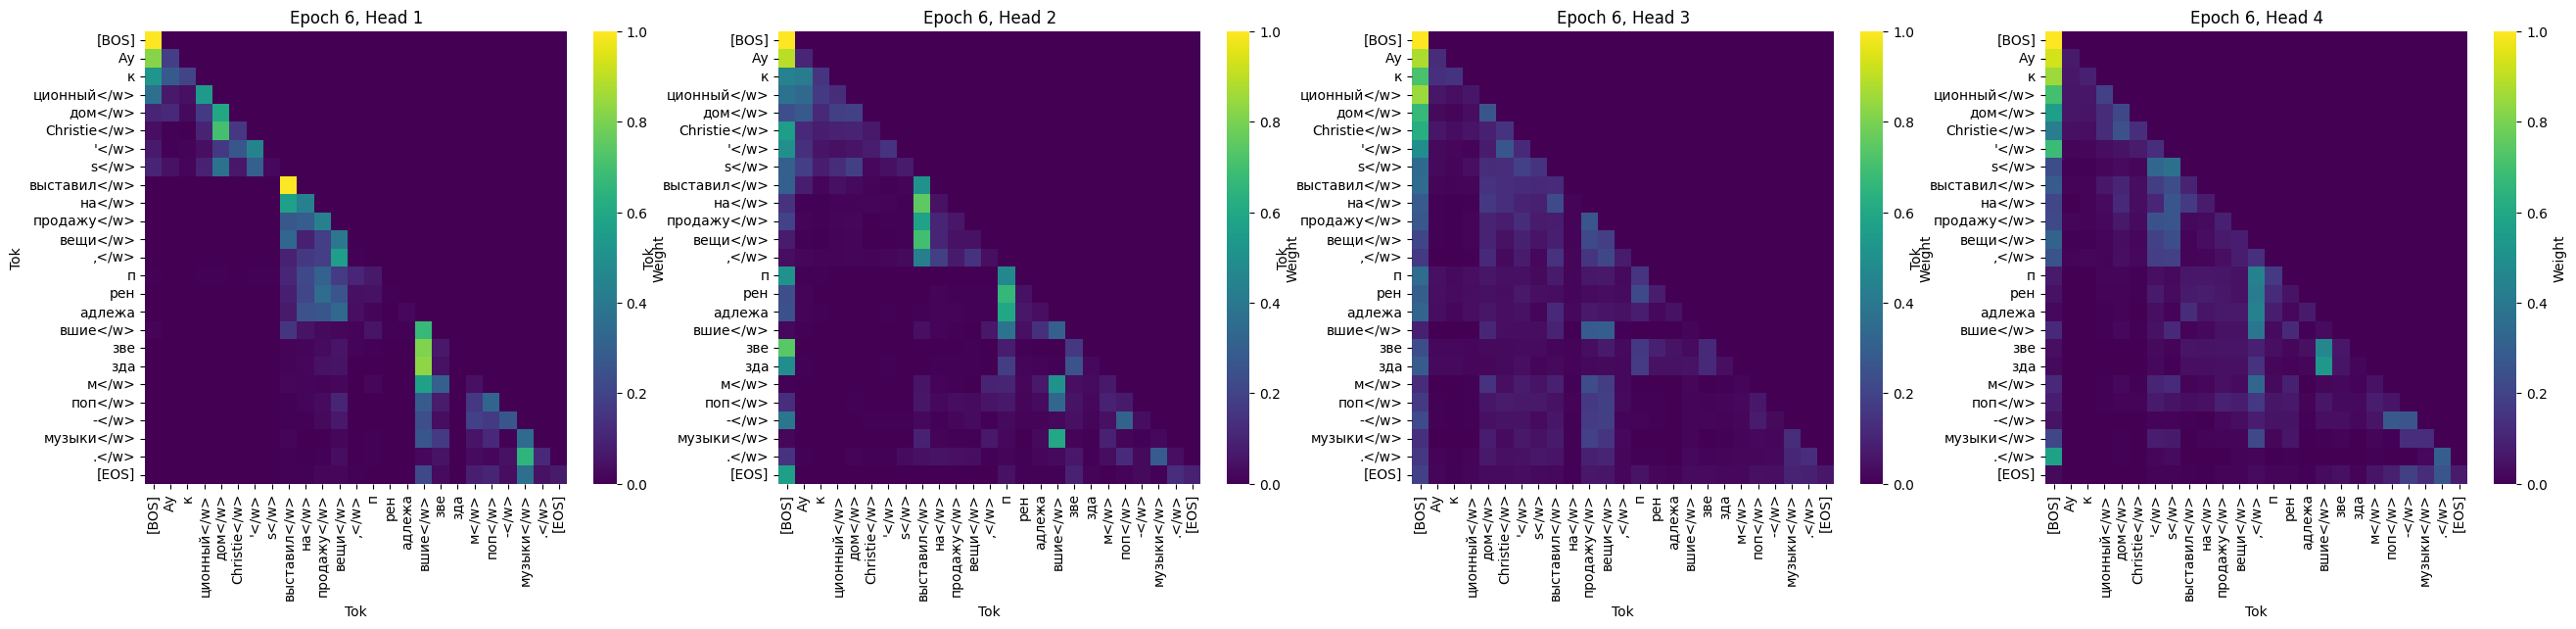

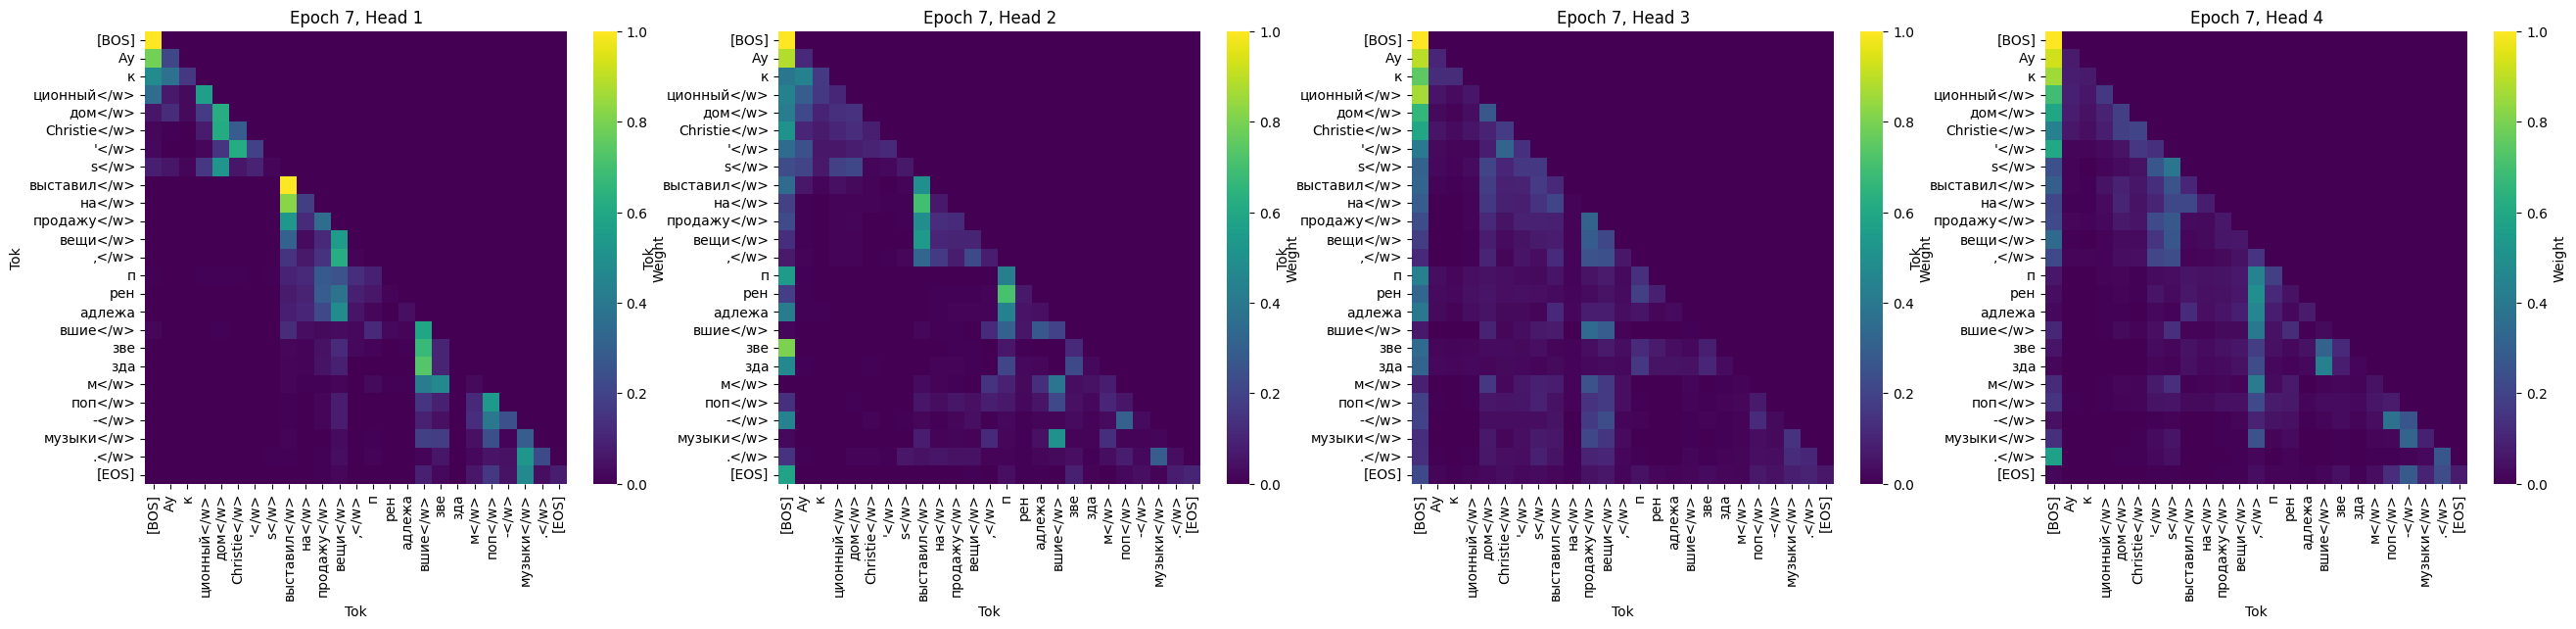

In [ ]:
for epoch in range(max(epoch_to_attentions)):

    ##  Нужно скопировать матрицы из памяти куды в обычную
    ##  И подрезать паддинг-токены
    ##  NOTE: если ничего не резать, можно увидеть, как 24й токен раздает кучу атеншна всем падингам.
    attentions = [
        e.squeeze(0).cpu().numpy()[:new_size, :new_size]
        for e
        in epoch_to_attentions[epoch]
    ]

    fig, axes = plt.subplots(1, 4, figsize=(8 * 4, 6))

    for i_h, attention_matrix in enumerate(attentions):
        sns.heatmap(
            attention_matrix,
            cmap="viridis",
            ax=axes[i_h],
            vmin=0,
            vmax=1,
            cbar_kws={"label": "Weight"},
            xticklabels=sample_tokens,
            yticklabels=sample_tokens,
            )
        axes[i_h].set_title(f"Epoch {epoch}, Head {i_h+1}")
        axes[i_h].set_xlabel("Tok")
        axes[i_h].set_ylabel("Tok")
